# Predicting Sales Prices

 ## Dataset Attributes

 The dataset contains information about houses in Ames, Iowa. The data was collected by the Ames City Assessor’s Office describing 2930 property sales which occurred in Ames, Iowa between 2006 and 2010. The dataset, containing 81 variables, was compiled and published by De Cock in 2011.

 Some of the variables contained in the original dataset have been removed from the the dataset provided to you.
 The dataset provided to you contains the following variables:
* **Year_Built:** year that the house was originally constructed
* **Year_Remod_Add:** year that the house was last remodelled
* **Total_Bsmt_SF:** total size of basement area in square feet
* **First_Flr_SF:** size of the first floor in square feet
* **Second_Flr_SF:** size of the second floor in square feet
* **Gr_Liv_Area:** size of above grade, ground living area in square feet
* **Full_Bath:** number of full above grade bathrooms in the house
* **Half_Bath:** number of half above grade bathrooms in the house
* **Bedroom_AbvGr:** number of above grade bedrooms (does not include basement bedrooms)
* **Kitchen_AbvGr:** number of above grade kitchens
* **TotRms_AbvGrd:** total number of above grade rooms (does not include bathrooms)
* **Fireplaces:** number of fireplaces in the house
* **Garage_Area:** size of garage in square feet
* **Sale_Price:** sale price of the house in dollars


*De Cock, D. (2011). "Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester
Regression Project," Journal of Statistics Education, Volume 19, Number 3.*

- https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt
- http://ww2.amstat.org/publications/jse/v19n3/decock.pdf


 ## Objective

 The goal of this task is to analyse the relationship between these variables and build a multiple linear regression model to predict the sales prices based on the 'Gr_Liv_Area' and 'Garage_Area` variables.


## Libraries

In [270]:
# Import libraries
from collections import defaultdict
import pandas as pd
import numpy as np
from mlxtend.preprocessing import minmax_scaling, standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

## Load the dataset

In [465]:
# Load the data set
dataset = pd.read_csv("ames.csv")

## Look at dataset

In [3]:
# Brief look at the dataset
print(dataset.columns.tolist())

dataset.head(5)

['Year_Built', 'Year_Remod_Add', 'Total_Bsmt_SF', 'First_Flr_SF', 'Second_Flr_SF', 'Gr_Liv_Area', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd', 'Fireplaces', 'Garage_Area', 'Sale_Price']


,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price
0,1960,1960,1080,1656,0,1656,1,0,3,1,7,2,528,215000
1,1961,1961,882,896,0,896,1,0,2,1,5,0,730,105000
2,1958,1958,1329,1329,0,1329,1,1,3,1,6,0,312,172000
3,1968,1968,2110,2110,0,2110,2,1,3,1,8,2,522,244000
4,1997,1998,928,928,701,1629,2,1,3,1,6,1,482,189900


## Clean and pre-process the data


### Investigate missing data

On the next step, the objective is to find all the features which may contain missing data.

The approach taken was to loop on all the features in the dataset, and calculate a nan rate per each by simply counting the number of nan values and dividing this number to the total number of records under each feature.

Based on the results of this inspection, fortunately all the features have 0 nan rate thus none of them miss any data points.

In [4]:
# Discovering the features with missing data

# Getting a list of all the columns
columns_list = dataset.columns.tolist()

# Per each feature in the dataset a nan rate will be calculated
# By dividing the number of nan values to the total number of data points
for column in columns_list:
    nan_rate = dataset.loc[dataset[column].isna()].shape[0] / dataset.shape[0]
    print(f"The nan rate of the column {column}: {nan_rate}")

The nan rate of the column Year_Built: 0.0
The nan rate of the column Year_Remod_Add: 0.0
The nan rate of the column Total_Bsmt_SF: 0.0
The nan rate of the column First_Flr_SF: 0.0
The nan rate of the column Second_Flr_SF: 0.0
The nan rate of the column Gr_Liv_Area: 0.0
The nan rate of the column Full_Bath: 0.0
The nan rate of the column Half_Bath: 0.0
The nan rate of the column Bedroom_AbvGr: 0.0
The nan rate of the column Kitchen_AbvGr: 0.0
The nan rate of the column TotRms_AbvGrd: 0.0
The nan rate of the column Fireplaces: 0.0
The nan rate of the column Garage_Area: 0.0
The nan rate of the column Sale_Price: 0.0


### Investigate the features' underlying distribution

The underlying distribution of the data points belonging to each feature is of outmost importance. 


The trend found in each distribution is the key to the type of scaling transformation happening on the data.

If the trend is following a Gaussian or a normal distribution, then the most appropriate option would be using Standardisation method.

Else, the Normalisation method would be the alternative.

For depicting the shape of the underlying distribution of each feature, histograms per each feature will be plotted in separate subplots.

In [5]:
# Plot the distribution of the data
def plot_data_distribution(data, columns):
    """
    The function which plots the histogram of all the features in a dataset
    Parameters
    ----------
    data : pd.DataFrame
        the dataset
    columns : list
        the list of all the features
    """
    # Setting up the subplot positions and figure size
    fig, ax = plt.subplots(7, 2, figsize=(20, 30))

    # The counters used to locate each subplot
    row_counter = 0
    col_counter = 0

    # Iterating through the columns list
    # To plot histogram of each column separately
    for i in range(len(columns)):
        # Histogram plot
        sns.histplot(data[columns[i]], ax=ax[row_counter][col_counter], kde=True)
        # Incrementing the counters
        # To index the right subplot each time
        if col_counter < 1:
            col_counter += 1
        else:
            col_counter = 0
            row_counter += 1

    # Setting a general title for the whole figure
    fig.suptitle("Histograms of all the features in the dataset", fontsize=14)
    # Adjusting the position of the title and the space between the plot
    # https://stackoverflow.com/questions/39331143/huge-space-between-title-and-plot-matplotlib
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

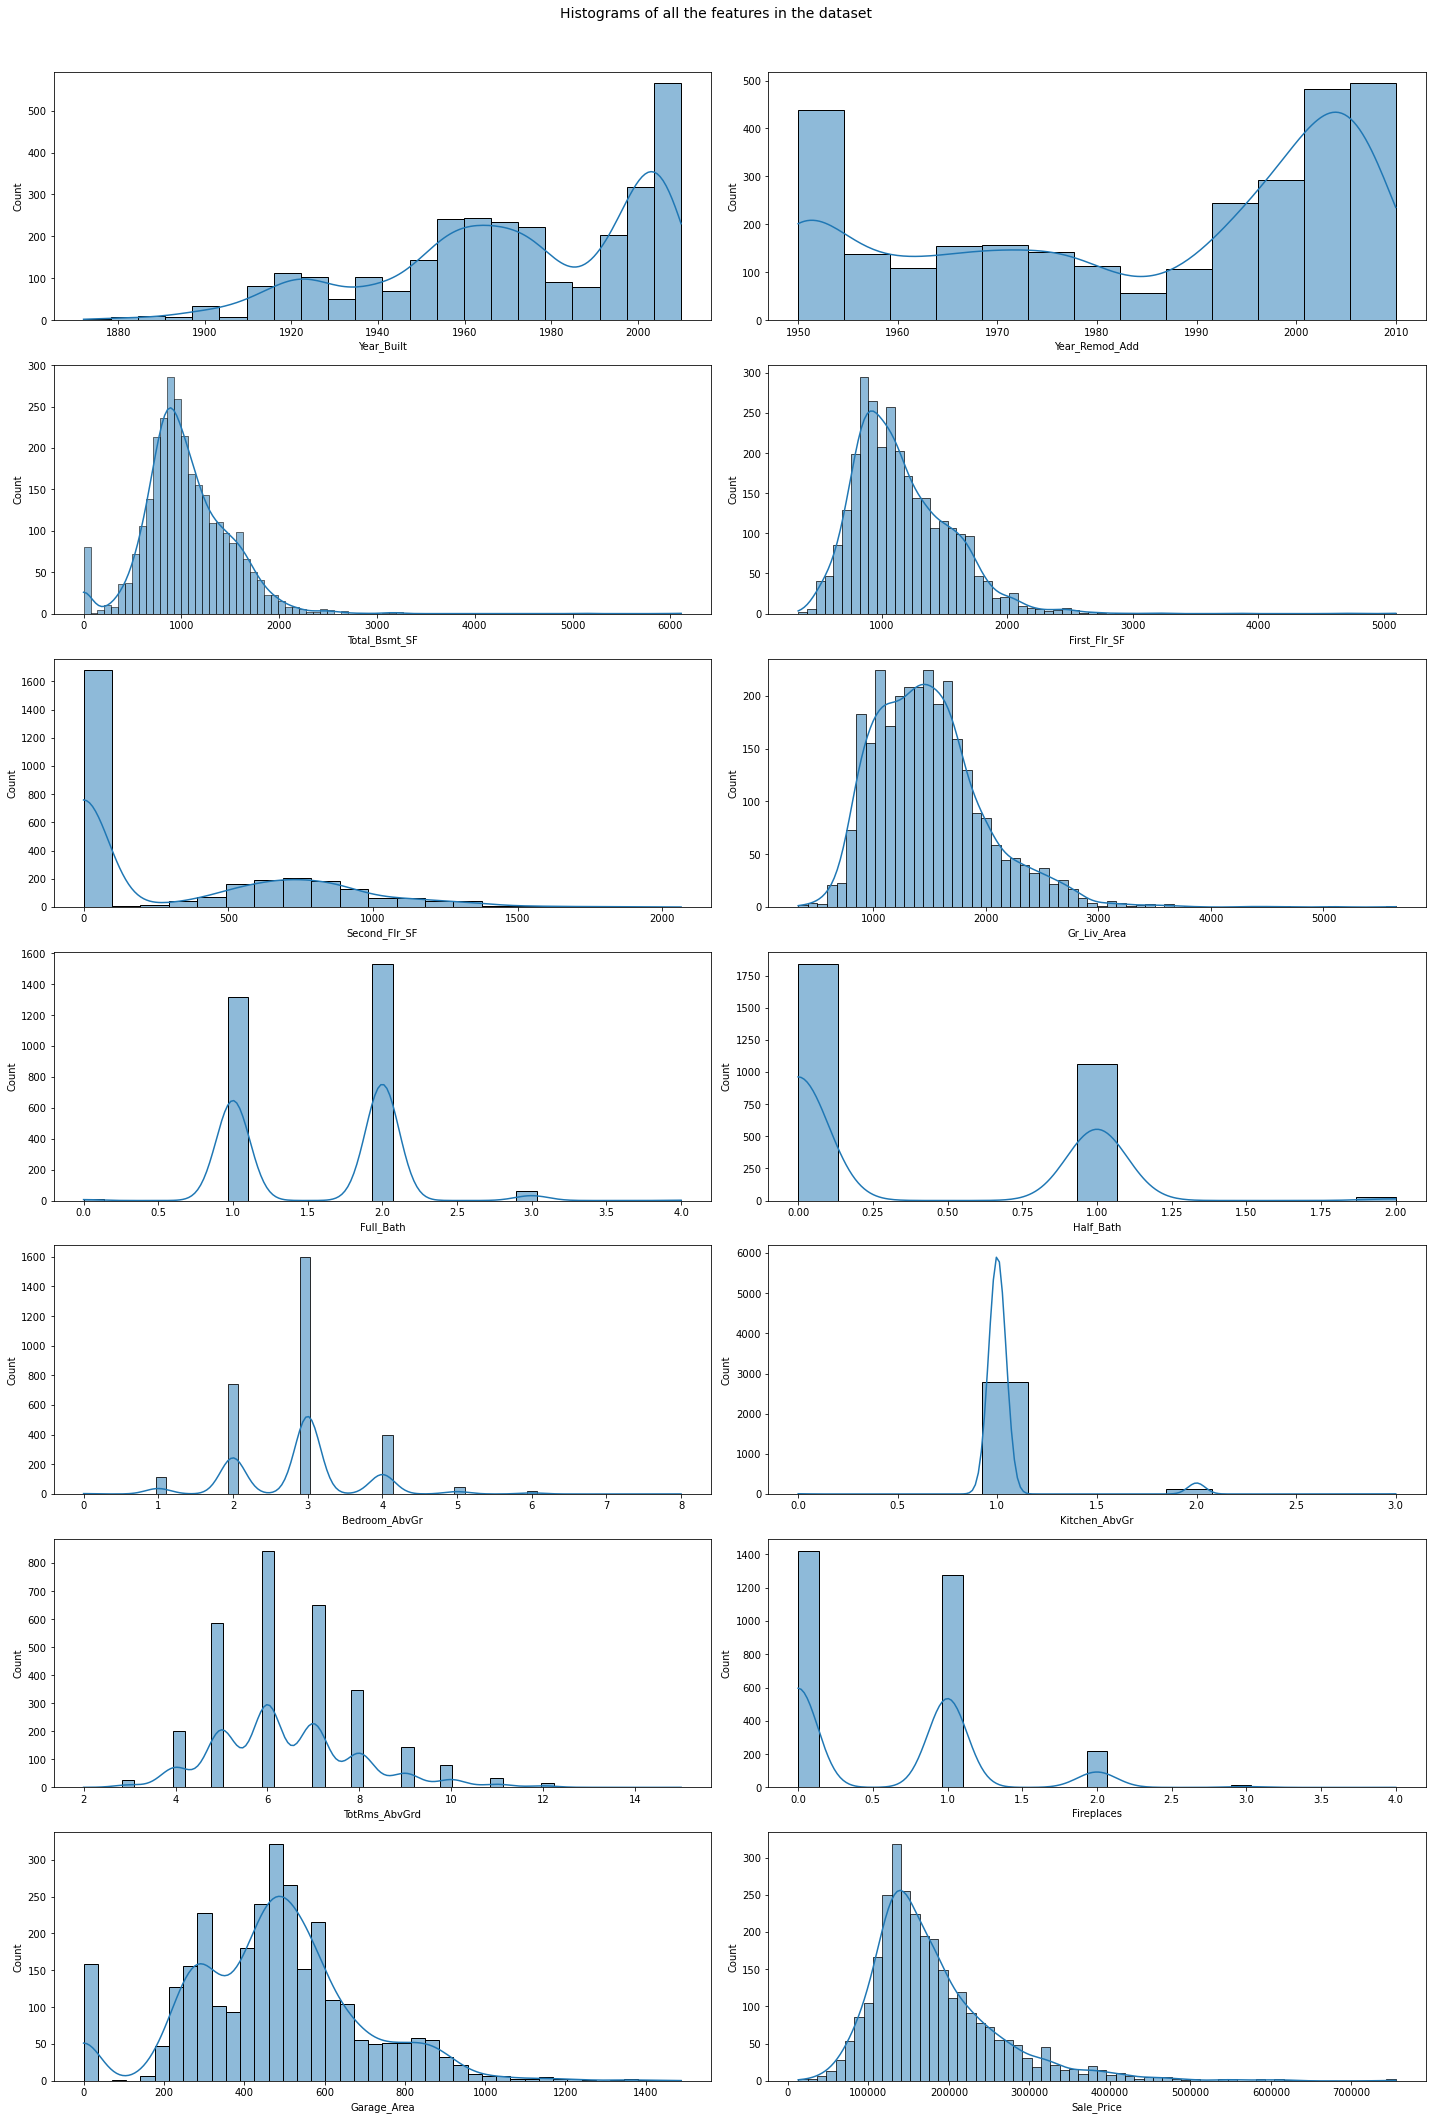

In [6]:
plot_data_distribution(data=dataset, columns=columns_list)

Based on the histograms, the following features' trends resemble Gaussian distribution:

- 'Total_Bsmt_SF'
- 'First_Flr_SF'
- 'Gr_Liv_Area'
- 'Sale_Price'

These features will be transformed using Standardisation.


And the following features will be transformed using Normalisation:

- 'Year_Built'
- 'Year_Remod_Add'
- 'Second_Flr_SF'
- 'Full_Bath'
- 'Half_Bath'
- 'Bedroom_AbvGr'
- 'Kitchen_AbvGr'
- 'TotRms_AbvGrd'
- 'Fireplaces'
- 'Garage_Area'

It is a better practice to transform the data after splitting it to training and test set.

This way the information from the test set won't be leaked to the scaler and have a general impact on the prediction process, since from this point forward in all the future steps there is some information from test set going around.

This case won't lead us to an ideal outcome since the idea is to have zero information involved in during training the model.

Still, it could be worth having an overview of how the data might look after scaling:

In [7]:
def plot_original_data_vs_scaled_data(data, column, normal_feat):
    """
    The function which plots the histogram of the given feature
    Next scales the feature
    And plots the histogram of the feature after scaling

    Parameters
    ----------
    data : pd.DataFrame
        the dataset
    column : string
        the name of the feature
    normal_feat: list
        the list containing the name of the features
        following Normal distribution
    """
    # Setting up the subplot positions and figure size
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.tight_layout()

    # To plot histogram of each column separately

    # Histogram plot
    sns.histplot(data[column], ax=ax[0], kde=True)
    ax[0].set_title("Original Distribution")
    ax[0].set_xlabel(column)
    # Histogram plot after scaling
    if column in normal_feat:
        scaled_data = standardize(data[column], columns=[0])
    else:
        scaled_data = minmax_scaling(data[column], columns=[0])
    # Incrementing the counters
    # To index the right subplot each time
    sns.histplot(scaled_data, ax=ax[1], kde=True)
    ax[1].set_title("Scaled Distribution")
    ax[1].set_xlabel(column)

    fig.suptitle(f"Histograms of {column} before and after scaling", fontsize=14)
    fig.subplots_adjust(top=0.85)

    plt.show()

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


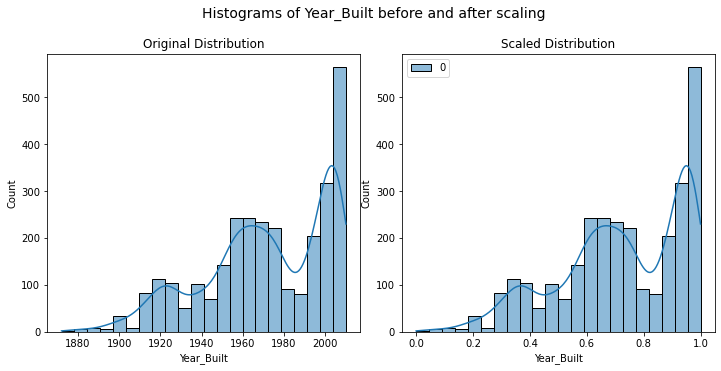

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


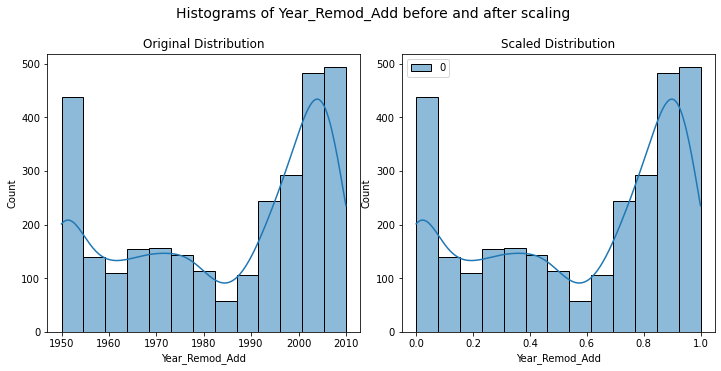

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:104: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


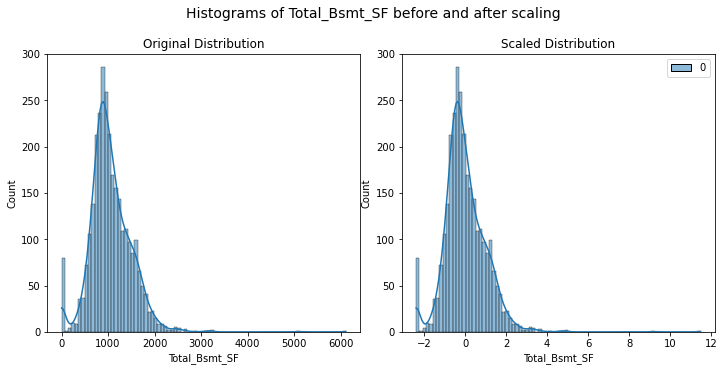

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:104: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


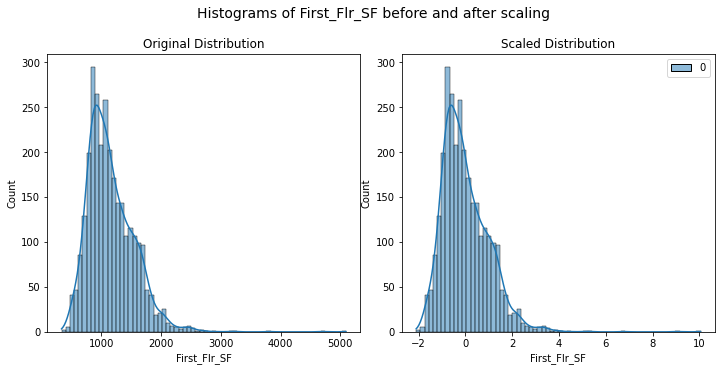

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


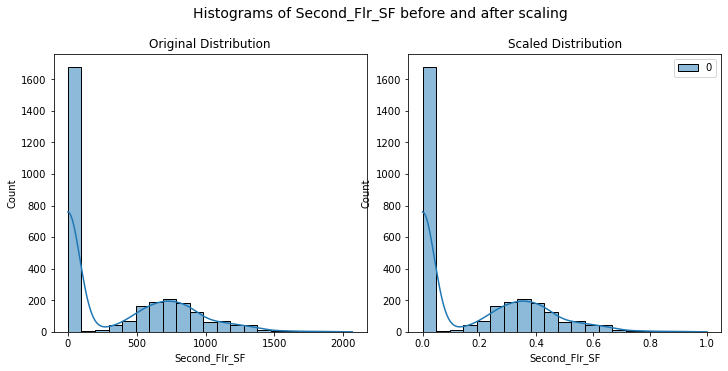

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:104: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


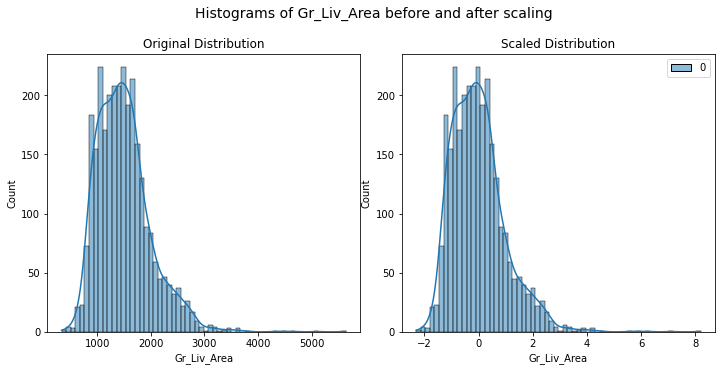

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


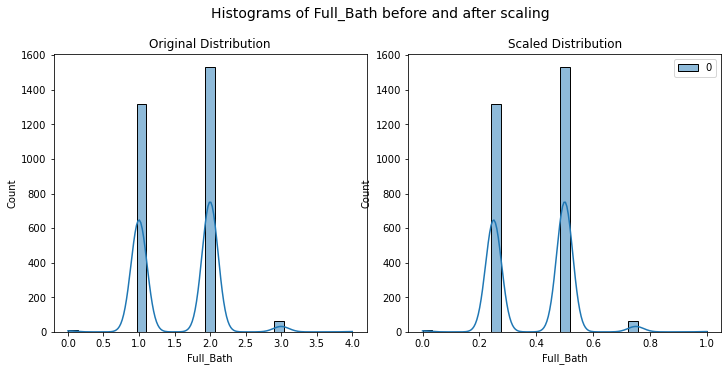

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


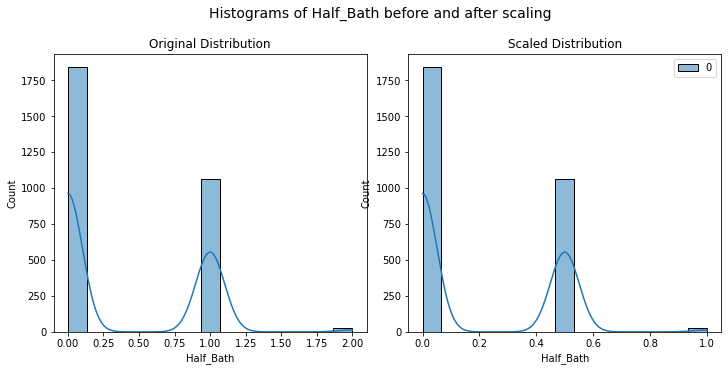

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


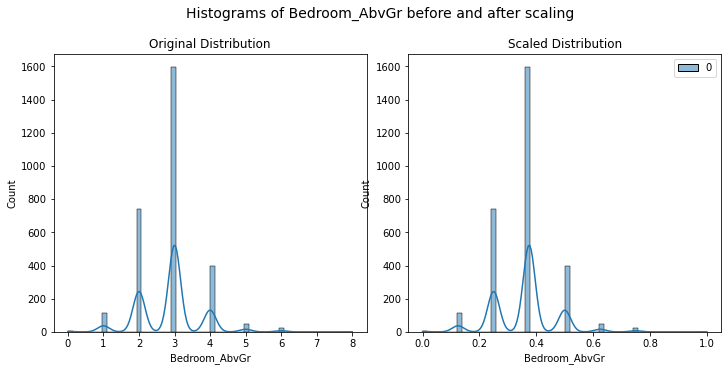

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


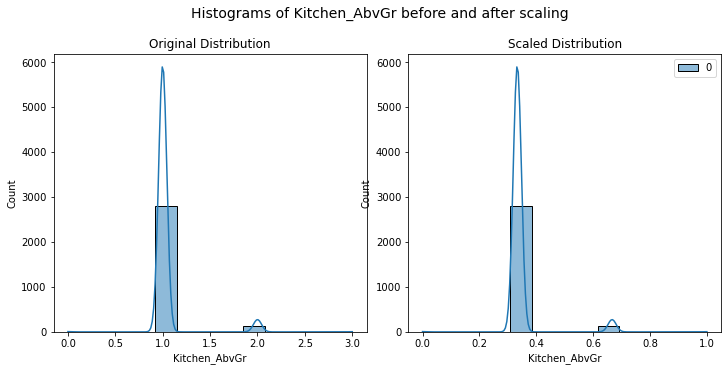

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


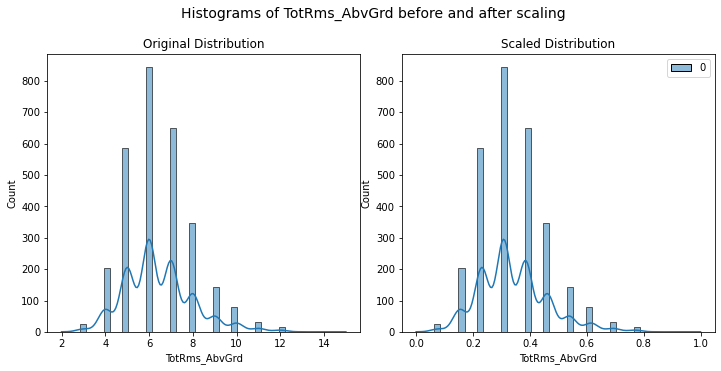

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


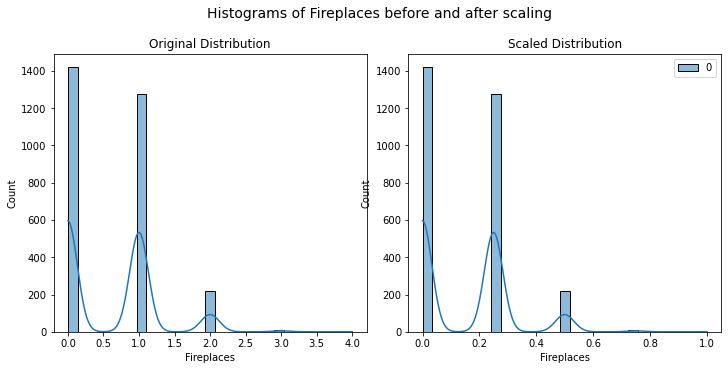

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


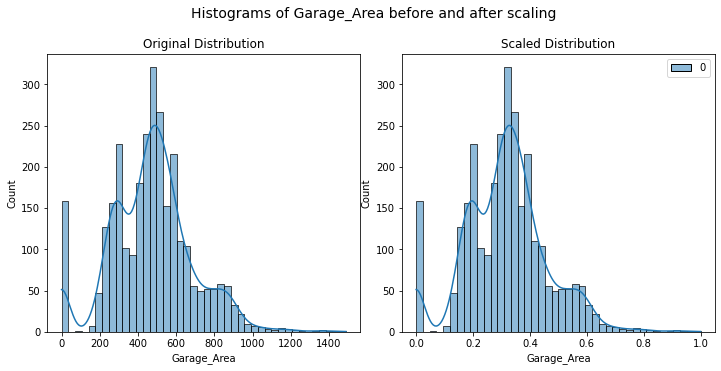

/Users/zahrasoheilasoheili/.local/lib/python3.8/site-packages/mlxtend/preprocessing/scaling.py:104: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


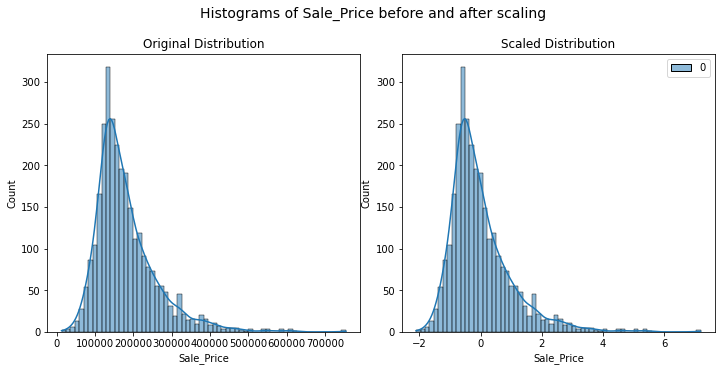

In [8]:
# Plotting the scaled data
gaussian_features = ["Total_Bsmt_SF", "First_Flr_SF", "Gr_Liv_Area", "Sale_Price"]
non_gaussian_features = [
    "Year_Built",
    "Year_Remod_Add",
    "Second_Flr_SF",
    "Full_Bath",
    "Half_Bath",
    "Bedroom_AbvGr",
    "Kitchen_AbvGr",
    "TotRms_AbvGrd",
    "Fireplaces",
    "Garage_Area",
]
for column in columns_list:
    plot_original_data_vs_scaled_data(
        data=dataset, column=column, normal_feat=gaussian_features
    )

## Explore the data and correlation between features

It is of utmost importance to gain insight on the trends amongst the features, and discover the potential correlations amongs pairs of features.

This step can be considered as some sort of feature engineering, where valuable informations are uncovered and the interesting facts will be of advantage for when the independent and dependent variables are going to be scoped out for the future prediction model.



In [9]:
# Instantiating scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply StandardScaler to Guassian featuresg
scaled_height_weight = standard_scaler.fit_transform(dataset[gaussian_features])

# Apply MinMaxScaler to Other features
scaled_age = minmax_scaler.fit_transform(dataset[non_gaussian_features])

# Convert scaled arrays back to DataFrames
scaled_height_weight_df = pd.DataFrame(scaled_height_weight, columns=gaussian_features)
scaled_age_df = pd.DataFrame(scaled_age, columns=non_gaussian_features)

# Concatenate the scaled DataFrames
scaled_data = pd.concat([scaled_height_weight_df, scaled_age_df], axis=1)

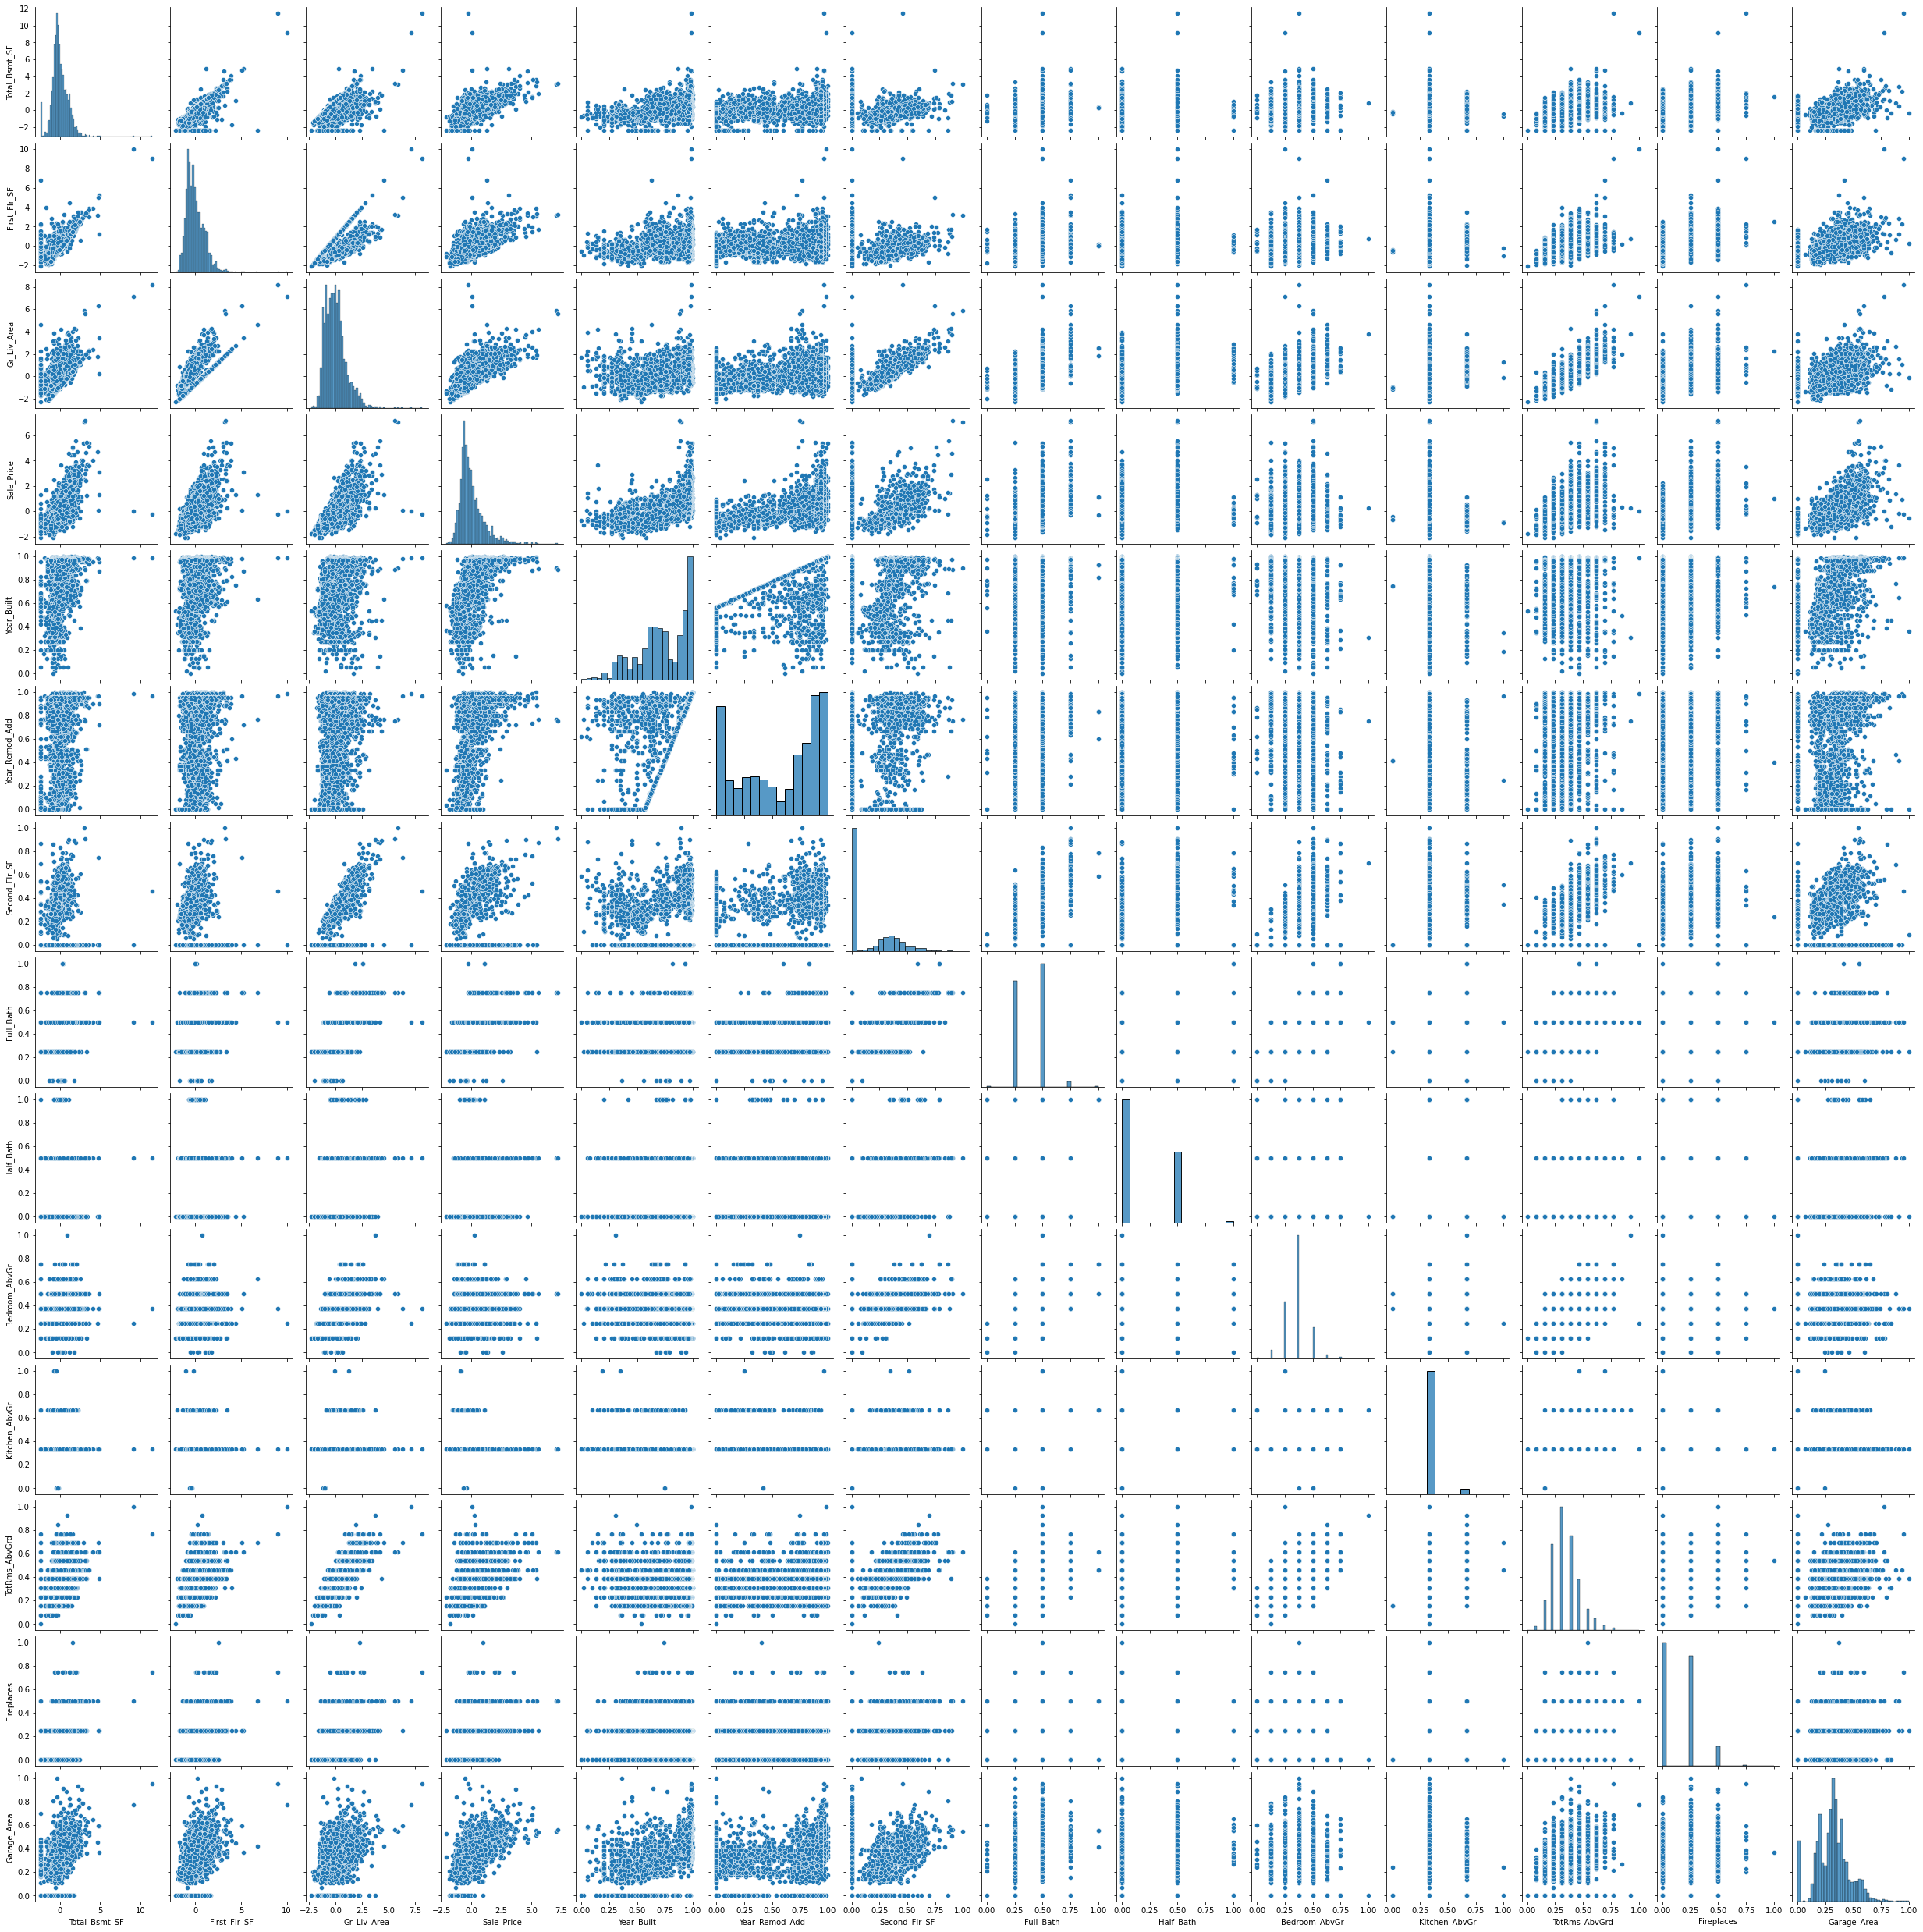

In [10]:
# Pairplot of all the features in the dataset
# Plotting features two by two against each other
# The plots on the diagonal are histograms of each features
sns.pairplot(data=scaled_data)

It might be challenging to look at the plot above and managing to extract all the useful and important information out of it considering the fact that the number of variables are high and it can be difficult to keep track of everything.

A measurement of correlation between features in pairs might a better approach. Since it potentially gives a more tangible sense of relations between the variables.

For this purpose, we use the correlation matrix.
The rows and columns of this matrix will each represent a feature. And each cell contains the correlation of the coefficients belonging to the features.

The correlations will be in an spectrum from -1 to 1, where 1 is the strongest correlation and -1 is a negative correlation. 

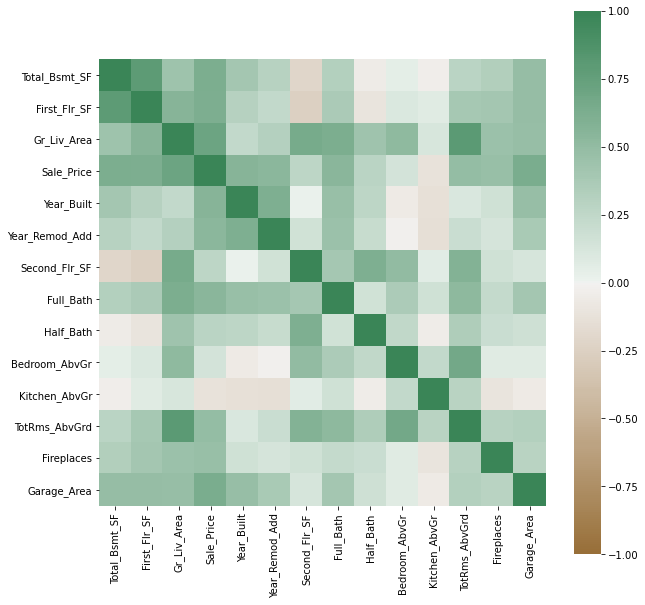

In [11]:
# Plotting a correlation matrix using all the features in the dataset
# Showing the relation between the features

# https://www.w3schools.com/datascience/ds_stat_correlation_matrix.asp
correlation_data = scaled_data.corr()

plt.figure(figsize=(10, 10))

axis_corr = sns.heatmap(
    correlation_data,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(50, 500, n=500),
    square=True,
)

plt.show()

The heatmap above gives a closer overview of the relation between the features. 

The diagonal cells are all equal to 1 since the correlation of all the variables with themselves is the maximum it can get.

Since the correlation between the features are now calculated, it is noteworthy to find the closest correlated features and rank them.

In [12]:
# The list which will keep the tuples of pairs of features
# For skipping the duplicate pairs
high_correlated = []
# A dataframe which will contain the feature pairs in two different columns
# Following their correlation measure in a third column
high_correlated_df = pd.DataFrame(columns=["Feature1", "Feature2", "Corr"])

# Lists which will populate the 'high_correlated_df' dataframe
first_features = []
second_features = []
correlation_vals = []

# Iterating through the columns of the original dataset
# To check all the possible combinations of the feature pairings
for column_axis_0 in columns_list:
    for column_axis_1 in columns_list:
        # Checking if the correlation is signifacnt enough
        # Choosing only the ones more than 0.5 and less than 1
        # Skipping the correlations of features with themselves and weak ones
        if (
            correlation_data[column_axis_0][column_axis_1] > 0.5
            and correlation_data[column_axis_0][column_axis_1] < 1
        ):
            if (column_axis_0, column_axis_1) not in high_correlated and (
                column_axis_1,
                column_axis_0,
            ) not in high_correlated:
                # Saving the strong correlation's parameters
                high_correlated.append((column_axis_0, column_axis_1))
                first_features.append(column_axis_0)
                second_features.append(column_axis_1)
                correlation_vals.append(
                    round(correlation_data[column_axis_0][column_axis_1], 4)
                )

# Populating the dataframe
high_correlated_df["Feature1"] = first_features
high_correlated_df["Feature2"] = second_features
high_correlated_df["Corr"] = correlation_vals

# Sorting and showing the high correlated pairs by their correlations
high_correlated_df.sort_values(by="Corr", ascending=False)

,Feature1,Feature2,Corr
13,Gr_Liv_Area,TotRms_AbvGrd,0.8078
3,Total_Bsmt_SF,First_Flr_SF,0.8004
14,Gr_Liv_Area,Sale_Price,0.7068
17,Bedroom_AbvGr,TotRms_AbvGrd,0.6726
7,Second_Flr_SF,Gr_Liv_Area,0.6553
18,Garage_Area,Sale_Price,0.6401
4,Total_Bsmt_SF,Sale_Price,0.6325
11,Gr_Liv_Area,Full_Bath,0.6303
6,First_Flr_SF,Sale_Price,0.6217
0,Year_Built,Year_Remod_Add,0.6121


And Finally a list of the variables with the number of times they appeared in a strong correlation.

It is worth considering that the dependent variable 'Sale_price' of our purpose appears the most in a strong correlation with other variables.

In [527]:
# Counting the number of times a variable was a part of highly correlated pair
all_correlated_features = []
all_correlated_features.extend(first_features)
all_correlated_features.extend(second_features)

# https://stackoverflow.com/questions/2161752/how-to-count-the-frequency-of-the-elements-in-an-unordered-list
appearances = defaultdict(int)

for curr in all_correlated_features:
    appearances[curr] += 1

appearances

defaultdict(int,
            {'Year_Built': 2,
             'Year_Remod_Add': 2,
             'Total_Bsmt_SF': 2,
             'First_Flr_SF': 3,
             'Second_Flr_SF': 4,
             'Gr_Liv_Area': 6,
             'Full_Bath': 3,
             'Bedroom_AbvGr': 3,
             'Garage_Area': 1,
             'Sale_Price': 7,
             'Half_Bath': 1,
             'TotRms_AbvGrd': 4})

## Split the independent variables from the dependent variable

Based on our question, which is trying to predict the prices of houses for sale judging by their other descriptive factors, the dependent variable is 'Sale_Price'.

In [46]:
# Split the independent variables from the dependent variable

# Independent variables
independent_variables = dataset.iloc[:, :13]
# Dependent variable
dependent_variable = dataset.iloc[:, 13]

In [47]:
independent_variables.head(5)

,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area
0,1960,1960,1080,1656,0,1656,1,0,3,1,7,2,528
1,1961,1961,882,896,0,896,1,0,2,1,5,0,730
2,1958,1958,1329,1329,0,1329,1,1,3,1,6,0,312
3,1968,1968,2110,2110,0,2110,2,1,3,1,8,2,522
4,1997,1998,928,928,701,1629,2,1,3,1,6,1,482


In [48]:
dependent_variable.head(5)

0    215000
1    105000
2    172000
3    244000
4    189900
Name: Sale_Price, dtype: int64

## Explore relationships between the independent and dependent variables

In [348]:
# Explore relationships between the independent and dependent variables
def explore_relation_between_x_y(x_set, y_set, x_name, y_name):
    """
    The function which plots the relation between an independent and dependent variable
    using a scatter plot and fits the variables to a linear regression model
    next plots the model in the same plot

    Parameters
    ----------
    x_set: pd.Series
        The series of the independent variable
    y_set: pd.Series
        The series of the dependent variable
    x_name: string
        The name of the independent variable
    y_name: string
        The name of the dependent variable
    """
    # Select and reshape data
    x = x_set.values
    y = y_set.values
    y = y.reshape(-1, 1)
    x = x.reshape(-1, 1)

    # Create an empty linear regression model
    simple_linear_model = LinearRegression()

    # Create the model using fit(x,y)
    simple_linear_model.fit(x, y)

    # Use model to make a prediction
    y_pred = simple_linear_model.predict(x)

    print(simple_linear_model.score(x, y))

    # Plot model and data
    plt.scatter(x, y, color="b")
    plt.plot(x, y_pred, color="r")
    plt.title(f"{x_name} vs {y_name}")
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

0.31183971554072076


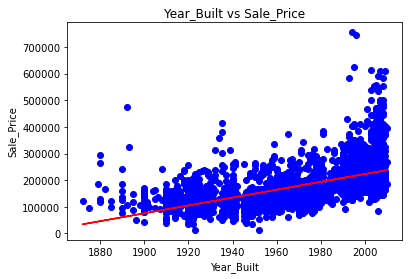

0.28406102248130816


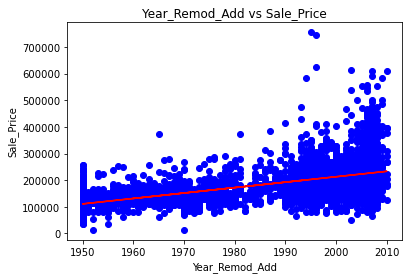

0.4000927448577878


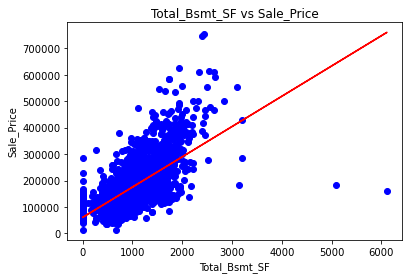

0.3864811276432


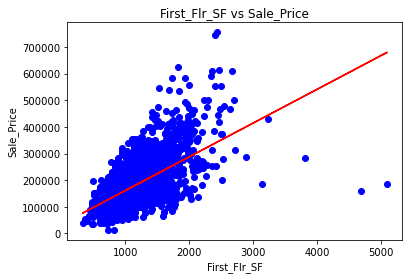

0.07256200524034317


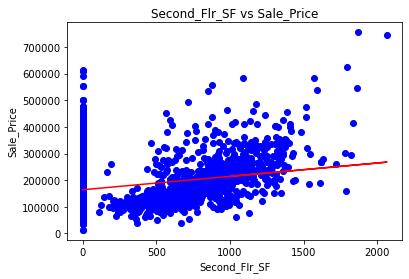

0.49953785669572837


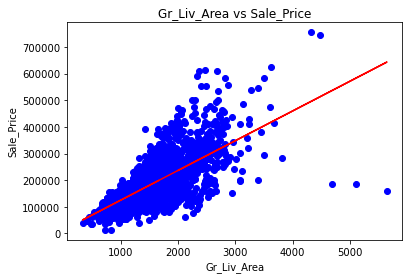

0.29768361626275885


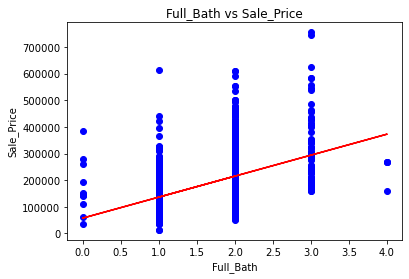

0.08125694111659443


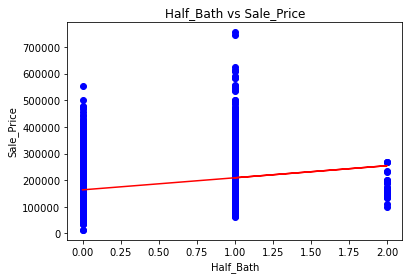

0.020711074873950075


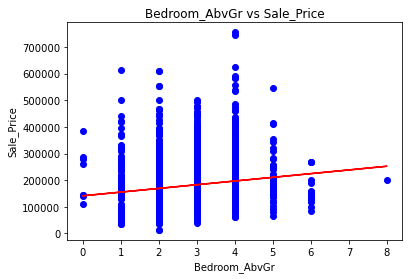

0.014355327554650854


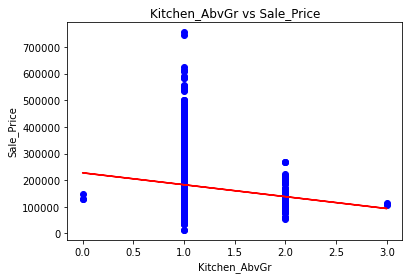

0.24549489775981848


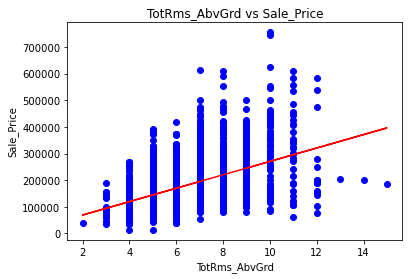

0.22520538324434536


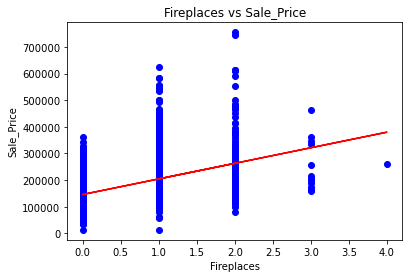

0.4097770411903089


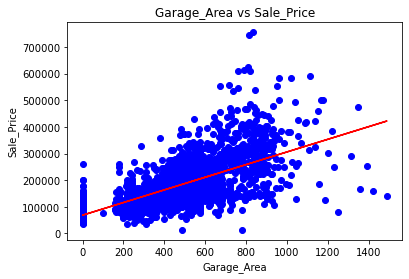

In [349]:
independent_vars_list = [
    "Year_Built",
    "Year_Remod_Add",
    "Total_Bsmt_SF",
    "First_Flr_SF",
    "Second_Flr_SF",
    "Gr_Liv_Area",
    "Full_Bath",
    "Half_Bath",
    "Bedroom_AbvGr",
    "Kitchen_AbvGr",
    "TotRms_AbvGrd",
    "Fireplaces",
    "Garage_Area",
]
dependent_var = "Sale_Price"

for variable in independent_vars_list:
    explore_relation_between_x_y(
        x_set=independent_variables[variable],
        y_set=dependent_variable,
        x_name=variable,
        y_name=dependent_var,
    )

## Remove outliers from the data

In [504]:
def remove_outliers(data, column_name):
    """
    The function that removes outliers from the data
    using the quentils of the feature and defining thresholds
    ultimately removing all the data points which are located outside of the thresholds

    Parameters
    ----------
    data : pd.DataFrame
        the dataset
    column_name : String
        the name of the feature where the outliers check happens

    Returns
    -------
    data_cleaned : pd.DataFrame
        the new dataset with all the outliers removed from its feature

    """
    # https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[column_name][
        (data[column_name] < lower_bound) | (data[column_name] > upper_bound)
    ]
    data_cleaned = data[~dataset[column_name].isin(outliers)]
    return data_cleaned

In [495]:
# Removing outliers from the columns
data_cleaned = remove_outliers(dataset, "Gr_Liv_Area")
data_cleaned = remove_outliers(data_cleaned, "Garage_Area")

<ipython-input-494-d963f30f5927>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_cleaned = data[~dataset[column_name].isin(outliers)]


## Create a training and test set

In [515]:
# Create a training and test set with a 75:25 split ratio


x = data_cleaned[["Gr_Liv_Area", "Garage_Area"]].values
y = data_cleaned["Sale_Price"].values
y = y.reshape(-1, 1)
x = x.reshape(-1, x.shape[1])

# Splitting the dataset into training and test set
rseed = 72
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=rseed
)

print("Training data:", X_train.shape, y_train.shape)
print("Test data:", X_test.shape, y_test.shape)

Training data: (2117, 2) (2117, 1)
Test data: (706, 2) (706, 1)


## Build a multiple linear regression model

In [520]:
# Scaling the data
# By fitting the scaler first to the training set
# Next transforming both sets

# Remembering 'Gr_Liv_Area' follows Gaussian distribution
gaussian_features = [0]
# List of column number which don't follow normal distribution
non_gaussian_features = [1]

# Define scaler using different scalers for different feature sets
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
# Setting the first scaler for the gaussian features and the next one for the rest
# By giving the transformer a name, instantiating the scaler,
# And giving each the list of the columns' index they need to transform
sc = ColumnTransformer(
    transformers=[
        ("gaussian", StandardScaler(), gaussian_features),
        ("non_gaussian", MinMaxScaler(), non_gaussian_features),
    ]
)

# Fit the scaler on the training set and then transforming it
X_train = sc.fit_transform(X_train)

# Transforming the test set using the fitted scaler
X_test = sc.transform(X_test)

In [521]:
# Fit a model
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## Print the model intercept and coefficients

In [522]:
# Create line coordinates
X_line = np.empty(X_test.shape)
for i in range(X_test.shape[1]):
    X_line[:, i] = np.linspace(
        np.min(X_test[:, i]), np.max(X_test[:, i]), num=X_test.shape[0]
    )
y_line = lm.predict(X_line)

print("Intercept: \n", lm.intercept_)
print("Coefficients: \n", lm.coef_)

Intercept: 
 [109146.96331753]
Coefficients: 
 [[ 34965.89460975 137035.37271677]]


## Generate predictions for the test set

In [523]:
# Generate predictions for the test set
predictions = lm.predict(X_test)

## Evaluate the model

In [524]:
# Evaluate the model
print("R2 Score:", round(model.score(X_test, y_test), 4))

error = mean_squared_error(y_test, predictions, squared=False)
print("RMSE:", error)

R2 Score: 0.6097
RMSE: 45078.43626901851


Text(0.5, 0, 'Garage_Area')

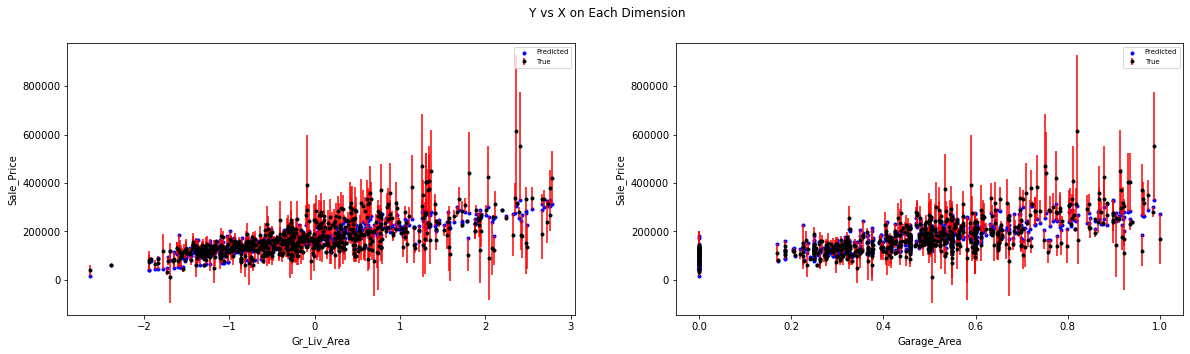

In [526]:
## Plot the errors
fig, ax = plt.subplots(1, X_test.shape[1], figsize=(20, 5))
fig.suptitle("Y vs X on Each Dimension")

# Get values for the error bar
error_bar_values = np.abs((y_test - predictions)[:, 0])


# Plot data, predicted values, and error bars
for i in range(X_test.shape[1]):
    ax[i].errorbar(
        X_test[:, i],
        y_test[:, 0],
        yerr=error_bar_values,
        fmt=".k",
        ecolor="red",
        label="True",
    )
    ax[i].scatter(X_test[:, i], predictions[:, 0], c="b", marker=".", label="Predicted")
    ax[i].legend(loc="best", fontsize="x-small")
    ax[i].set_ylabel("Sale_Price")

ax[0].set_xlabel("Gr_Liv_Area")
ax[1].set_xlabel("Garage_Area")

In [499]:
# Print the model intercept and coefficients
print("Intercept: \n", lm.intercept_)
print("Coefficients: \n", lm.coef_)

Intercept: 
 [88890.83417574]
Coefficients: 
 [[ 27938.74088249 183371.13828631]]


## Interpret coefficients in the context of the prediction

The coefficients associated with the two selected independent varibales, 'Gr_Liv_Area' and 'Garage_Area', are respectively: 27938.74088249 and 183371.13828631.

This means with each unit increase in 'Gr_Liv_Area', the price of the house would increase by 27938.74088249 units.

Same goes for the variable 'Garage_Area', with each unit increasing in this variable, the price of the property will increase by 183371.13828631 units.

The intercept describes the case where both 'Gr_Liv_Area' and 'Garage_Area' are equals to zero. In other words the price of the property without any of these options would be equal to 88890.83417574.


## Summarise findings

Based on the results plotted using error plots and the model's precision measured by the RMSE method, there is a significant difference between the predicted house prices and the actual prices. This indicates that the linear model is performing poorly on this dataset, and it may not be the best approach to use for making predictions on future cases.

As observed in the error plots, the majority of data points predicted by the linear model fall below the actual data points. This suggests that in reality, the prices predicted by this model would be considerably lower than their actual worth.

One potential solution to address this issue could be to incorporate more independent variables when training the model. However, this approach may not be effective since none of the independent variables individually exhibit a clear linear relationship with the dependent variable.

It may be worth exploring alternative modeling techniques that offer greater flexibility in capturing the relationship between the independent and dependent variables. These methods could provide a more accurate depiction of the underlying patterns in the data and lead to improved predictions.